# Part 3: Horse Race Prediction
## Classification Modelling
- In this section, we want to classify if a horse can win the race, and which three horses will be ranked in the top 3.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import joblib
import pickle
import time

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
# Read the train and test files
df_train = pd.read_csv('./data/df_train.csv', index_col=0)
df_test = pd.read_csv('./data/df_test.csv', index_col=0)
df_unseen = pd.read_csv('./data/df_unseen.csv', index_col=0)

In [3]:
# View the shape of the train and test files
print(df_train.shape)
print(df_test.shape)
print(df_unseen.shape)

(21139, 26)
(5286, 26)
(2939, 26)


In [4]:
# View the first 2 rows of the train file
df_train.head(2)

,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
finishing_position,,,,,,,,,,,,,,,,,,,,,
1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,1.0,...,NaN,2014-001,1,1.0,1400,1,1,1,6.058185,7.369681
2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,8.0,...,NaN,2014-001,2,2.0,1400,0,1,1,5.795734,6.721234


In [5]:
# View the first 2 rows of the test files
df_test.head(2)

,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
finishing_position,,,,,,,,,,,,,,,,,,,,,
1,11.0,SUPER FLUKE,T382,J Moreira,D Cruz,118,1118,6,-,4.0,...,NaN,2016-138,1/5/3/2/4/5,4.941176,1650,1,1,1,4.070707,8.052941
2,10.0,PEARL WARM WARM,T183,S Clipperton,P O'Sullivan,118,1099,12,SH,1.0,...,NaN,2016-138,2/3/8/7/1/6,5.266667,1650,0,1,1,6.714859,6.858209


In [6]:
# View the first 2 rows of the unseen file
df_unseen.head(2)

,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,running_position_1,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
finishing_position,,,,,,,,,,,,,,,,,,,,,
1,8.0,PRINCE HARMONY,V012,D Whyte,W Y So,119,1142,2,-,1.0,...,NaN,2016-564,1/13/9/6/10,7.800000,1200,1,1,1,5.795734,7.117705
2,2.0,GRACYDAD,V200,Z Purton,D J Hall,133,1092,7,SH,2.0,...,NaN,2016-564,2/1/6/3/3/3,6.352941,1200,0,1,1,5.343498,6.639836


In [7]:
# Keep the features we want to train our model on
X_train = df_train[['actual_weight', 'declared_horse_weight',
                    'draw', #'win_odds', 
                    'jockey_ave_rank',
                    'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]

y_train = df_train[['HorseWin', 'HorseRankTop3', 'HorseRankTop50Percent']]

# Keep the features we want to train our model on
X_test = df_test[['actual_weight', 'declared_horse_weight',
                   'draw', #'win_odds',
                   'jockey_ave_rank',
                    'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]
                    
y_test = df_test[['HorseWin', 'HorseRankTop3', 'HorseRankTop50Percent']]

# Keep the features we want for the unseen data
X_unseen = df_unseen[['actual_weight', 'declared_horse_weight',
                     'draw', #'win_odds',
                        'jockey_ave_rank',
                        'trainer_ave_rank', 'recent_ave_rank', 'race_distance']]



In [8]:
# View the shape of the train and test files
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(df_unseen.shape)

(21139, 7)
(21139, 3)
(5286, 7)
(5286, 3)
(2939, 26)


In [9]:
# Check the mean of the target variable
y_train.mean()

HorseWin                 0.080089
HorseRankTop3            0.239746
HorseRankTop50Percent    0.499361
dtype: float64

We can see that there is data imbalance for the HorseWin and HorseRankTop3 variables, so we need to account for these later when modelling.

In [10]:
# Specify kfold cross validation
kfold = KFold(n_splits=5)

### Define functions to run and evaluate models

In [11]:
# Create an empty dataframe to store the results
df_results = pd.DataFrame(columns=['Model', 'Prediction', 'CV-F1', 'F1 Score', 'AUC', 'Recall', 'Precision'])

In [18]:
# Define a function to run the model
def run_model(model, X_train, y_train, X_test, y_test, kfold):

    # Create a dataframe to store the predictions for the UNSEEN data
    df_pred = pd.DataFrame()
    df_pred['RaceID'] = df_unseen['race_id']
    df_pred['HorseID'] = df_unseen['horse_id']

    # Store model name
    model_name = str(model).split('(')[0]

    for column in ['HorseWin', 'HorseRankTop3']:

        # Print the column name
        print(f"Results for model {model_name} and target variable {column}:")
        
        # Fit the model
        model.fit(X_train, y_train[column].to_numpy())
        
        # Calculate the cross validation score
        cv_score = cross_val_score(model, X_train, y_train[column].to_numpy(), cv=kfold, scoring='f1_weighted').mean()
        cv_score = round(cv_score, 3)
        
        # Make predictions
        y_pred = model.predict(X_test)
        y_unseen_pred = model.predict(X_unseen)

        # Store the predictions in the dataframe
        df_pred[column] = y_unseen_pred
        
        # Calculate the f1 score
        f1 = f1_score(y_test[column].to_numpy(), y_pred, average='weighted')
        f1 = round(f1, 3)
        
        # Calculate PR AUC
        pr_auc = average_precision_score(y_test[column].to_numpy(), y_pred, average='weighted')
        pr_auc = round(pr_auc, 3)

        # Calculate Recall
        tn, fp, fn, tp = confusion_matrix(y_test[column].to_numpy(), y_pred).ravel()
        recall = tp / (tp + fn)
        recall = round(recall, 3)

        # Calculate Precision
        precision = tp / (tp + fp)
        precision = round(precision, 3)

        # Append the results to the dataframe
        df_results.loc[len(df_results)] = [model_name, column, cv_score, f1, pr_auc, recall, precision]

        # Print the results
        print('Cross Validation Score (F1-weighted): ', cv_score)
        print('F1 Score: ', f1)
        print('PR AUC (Avg Precision): ', pr_auc)
        print('Recall: ', recall)
        print('Precision: ', precision)

        # Plot confusion matrix
        plot_confusion_matrix(y_test, y_pred, column)

        # Plot precision recall curve
        plot_pr_auc(X_test, y_test, model, column)

    return df_pred

In [19]:
# Define plot confusion matrix function
def plot_confusion_matrix(y_test, y_pred, column):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_test[column].to_numpy(), y_pred)
    cm = pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], index=['Actual 0', 'Actual 1'])

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix for ' + column)
    plt.show()

In [20]:
# Define plot PR AUC function
def plot_pr_auc(X_test, y_test, model, column):
    # Get the probabilities of the predictions
    win_prob = model.predict_proba(X_test)[:, 1]

    # Get the precision and recall
    precision, recall, thresholds = precision_recall_curve(y_test[column], win_prob)

    # Calculate proportion of positive class
    proportion_pos_class = y_test[column].mean()
    
    # Print the PR AUC score
    pr_auc = round(auc(recall, precision),3)
    print(f'PR AUC score for {column}:', pr_auc)

    # Plot the PR AUC curve
    plt.figure(figsize = (8, 6))
    plt.plot([0, 1], [proportion_pos_class, proportion_pos_class], linestyle = '--')
    plt.plot(recall, precision, marker = '.')
    plt.title(f'PR AUC Curve for {column}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()    

### Model 1: Logistic Regression

In [21]:
# Initialize the model
lr = LogisticRegression()

In [22]:
# Do hyperparameter tuning
param_grid = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
                'penalty': ['l1', 'l2']}

grid = GridSearchCV(lr, param_grid, cv=kfold, scoring='f1_weighted', verbose=1, n_jobs=-1)

# find the best parameters
grid.fit(X_train, y_train['HorseWin'].to_numpy())

# Print the best parameters
print(grid.best_params_)
print(grid.best_score_)

# Initialize the model using best parameters
lr = grid.best_estimator_

Fitting 5 folds for each of 12 candidates, totalling 60 fits
{'C': 1, 'penalty': 'l2'}
0.8904642541320854


Results for model LogisticRegression and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.891
F1 Score:  0.891
PR AUC (Avg Precision):  0.113
Recall:  0.057
Precision:  0.667


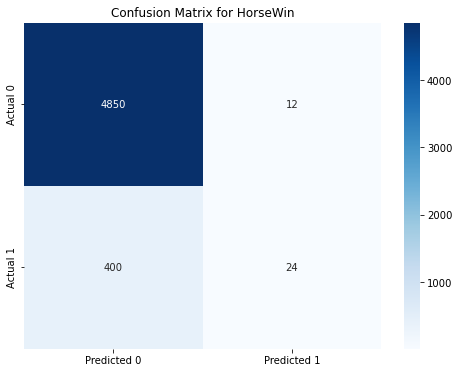

PR AUC score for HorseWin: 0.265


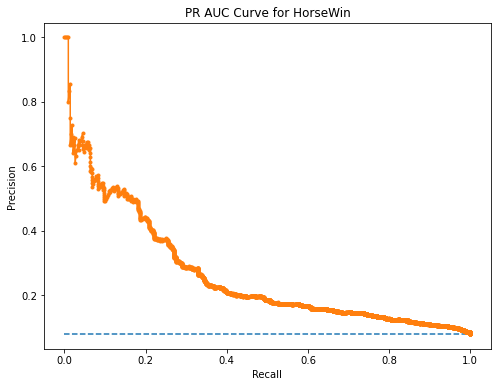

Results for model LogisticRegression and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.773
F1 Score:  0.749
PR AUC (Avg Precision):  0.337
Recall:  0.263
Precision:  0.611


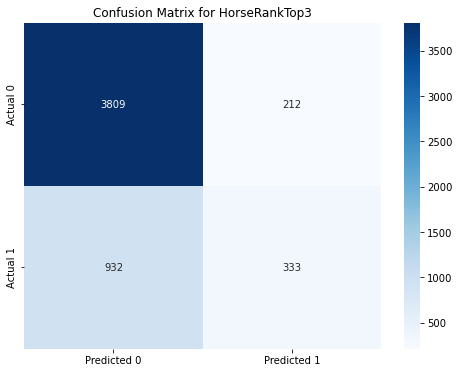

PR AUC score for HorseRankTop3: 0.511


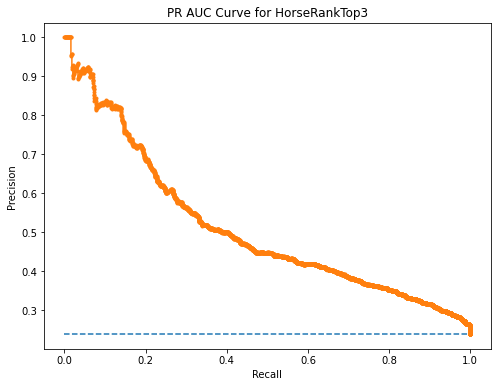

In [23]:
# Run Logistics Regression model
lr_pred = run_model(lr, X_train, y_train, X_test, y_test, kfold)

In [24]:
# Print the results
df_results

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.891,0.891,0.113,0.057,0.667
1,LogisticRegression,HorseRankTop3,0.773,0.749,0.337,0.263,0.611


### Model 2: Naive Bayes

In [25]:
# Initialize the model
gnb = GaussianNB()

In [26]:
# Do hyperparameter tuning
param_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]}

grid = GridSearchCV(gnb, param_grid, cv=kfold, scoring='f1_weighted', verbose=1, n_jobs=-1)

# find the best parameters
grid.fit(X_train, y_train['HorseWin'].to_numpy())

# Print the best parameters
print(grid.best_params_)
print(grid.best_score_)

# Initialize the model using best parameters
gnb = grid.best_estimator_

Fitting 5 folds for each of 13 candidates, totalling 65 fits
{'var_smoothing': 1e-06}
0.8915570982419379


Results for model GaussianNB and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.892
F1 Score:  0.889
PR AUC (Avg Precision):  0.121
Recall:  0.184
Precision:  0.304


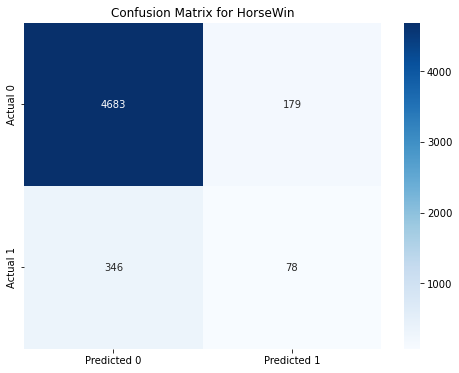

PR AUC score for HorseWin: 0.228


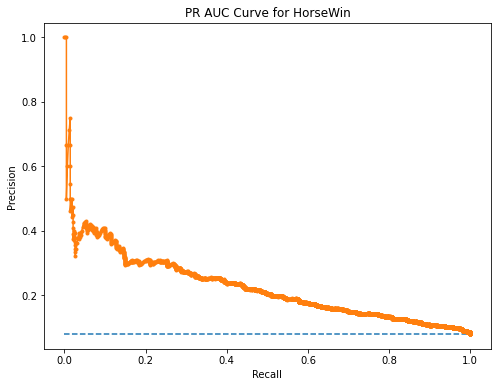

Results for model GaussianNB and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.77
F1 Score:  0.755
PR AUC (Avg Precision):  0.348
Recall:  0.39
Precision:  0.518


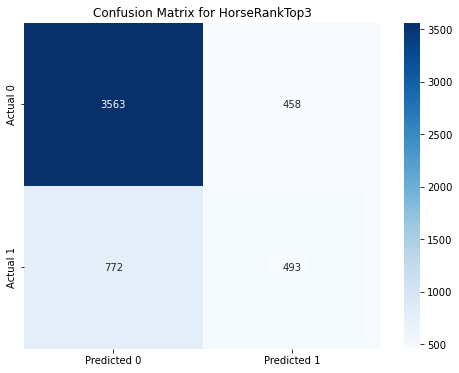

PR AUC score for HorseRankTop3: 0.486


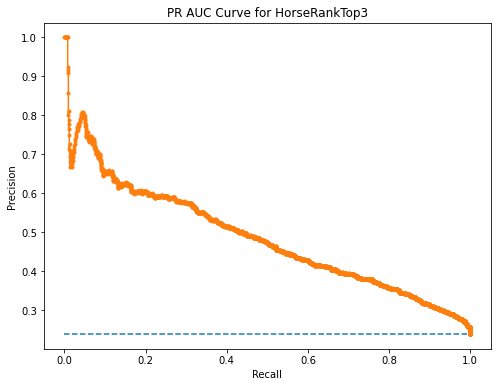

In [27]:
# Run Naive Bayes model
gnb_pred = run_model(gnb, X_train, y_train, X_test, y_test, kfold)

In [28]:
# Print the results
df_results

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.891,0.891,0.113,0.057,0.667
1,LogisticRegression,HorseRankTop3,0.773,0.749,0.337,0.263,0.611
2,GaussianNB,HorseWin,0.892,0.889,0.121,0.184,0.304
3,GaussianNB,HorseRankTop3,0.770,0.755,0.348,0.390,0.518


### Model 3: Random Forest Classifier

In [29]:
# Initialize the model
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)

In [30]:
# Do hyperparameter tuning
param_grid = {'max_depth': [20, 40],
                'max_features': [5, 10],
                'min_samples_leaf': [1, 2],
                'min_samples_split': [1, 2]}
grid = GridSearchCV(rfc, param_grid, cv=kfold, scoring='f1_weighted', verbose=1, n_jobs=-1)

# find the best parameters
grid.fit(X_train, y_train['HorseWin'].to_numpy())

# Print the best parameters
print(grid.best_params_)
print(grid.best_score_)

# Initialize the model using best parameters
rfc = grid.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
{'max_depth': 40, 'max_features': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
0.8989818799983766


Results for model RandomForestClassifier and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.899
F1 Score:  0.895
PR AUC (Avg Precision):  0.131
Recall:  0.087
Precision:  0.661


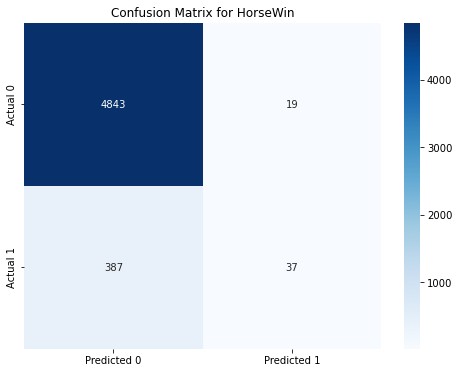

PR AUC score for HorseWin: 0.275


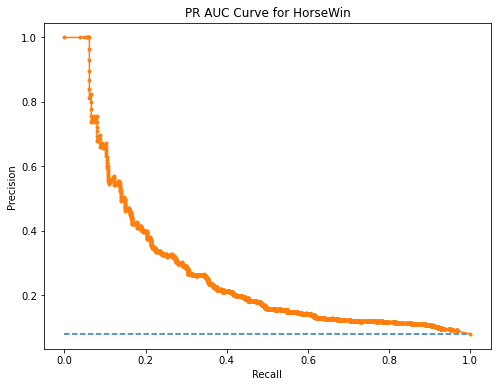

Results for model RandomForestClassifier and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.769
F1 Score:  0.75
PR AUC (Avg Precision):  0.337
Recall:  0.267
Precision:  0.605


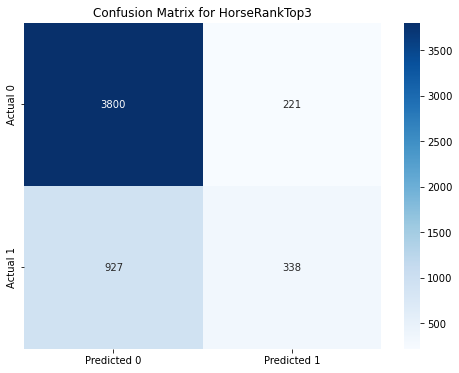

PR AUC score for HorseRankTop3: 0.508


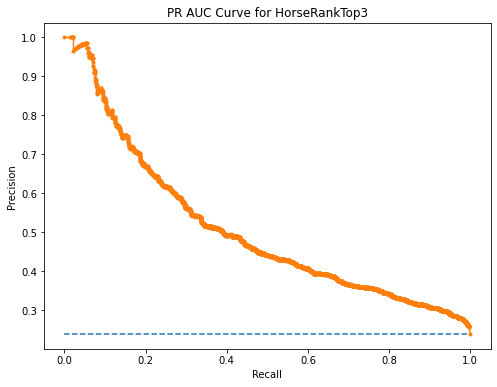

In [31]:
# Run Random Forest model
rfc_pred = run_model(rfc, X_train, y_train, X_test, y_test, kfold)

In [32]:
# Print the results
df_results

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.891,0.891,0.113,0.057,0.667
1,LogisticRegression,HorseRankTop3,0.773,0.749,0.337,0.263,0.611
2,GaussianNB,HorseWin,0.892,0.889,0.121,0.184,0.304
3,GaussianNB,HorseRankTop3,0.770,0.755,0.348,0.390,0.518
4,RandomForestClassifier,HorseWin,0.899,0.895,0.131,0.087,0.661
5,RandomForestClassifier,HorseRankTop3,0.769,0.750,0.337,0.267,0.605


### Model 4: SMOTE + Random Forest Classifier

In [33]:
# Smote the training data
sm = SMOTE(random_state = 42)
rfc = RandomForestClassifier(random_state = 42)

# Steps for the pipeline
steps = [('smote', sm), ('rfc', rfc)]

# Create the pipeline
smote_rfc = Pipeline(steps = steps)

Results for model Pipeline and target variable HorseWin:
Cross Validation Score (F1-weighted):  0.883
F1 Score:  0.715
PR AUC (Avg Precision):  0.107
Recall:  0.597
Precision:  0.124


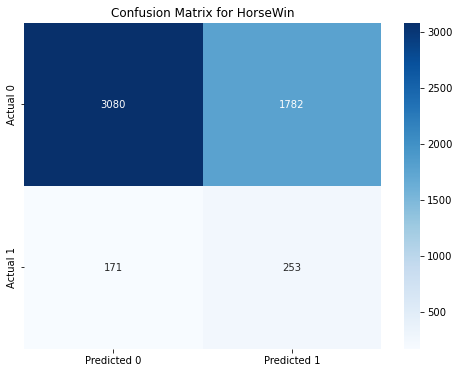

PR AUC score for HorseWin: 0.133


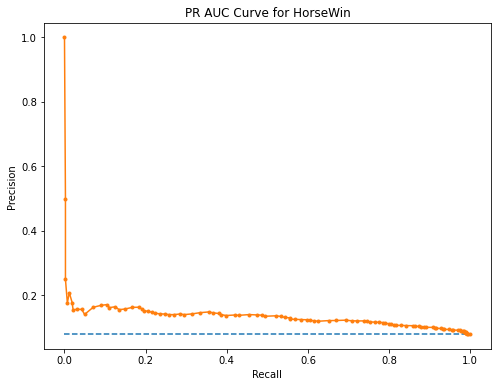

Results for model Pipeline and target variable HorseRankTop3:
Cross Validation Score (F1-weighted):  0.763
F1 Score:  0.634
PR AUC (Avg Precision):  0.322
Recall:  0.753
Precision:  0.35


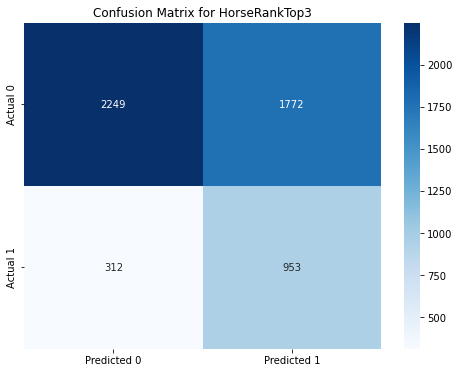

PR AUC score for HorseRankTop3: 0.42


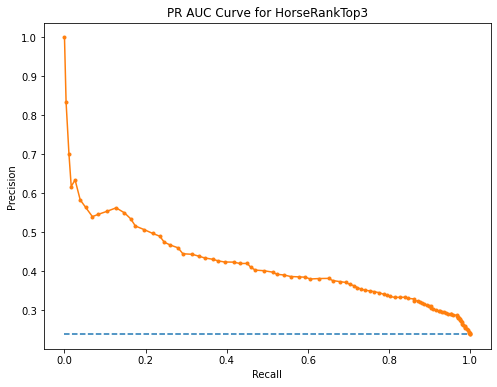

In [34]:
# Run the model
smote_rfc_pred = run_model(smote_rfc, X_train, y_train, X_test, y_test, kfold)

### View the final results of our 4 classification models

In [35]:
# View the results
df_results.sort_values(by='Prediction', ascending=False)

,Model,Prediction,CV-F1,F1 Score,AUC,Recall,Precision
0,LogisticRegression,HorseWin,0.891,0.891,0.113,0.057,0.667
2,GaussianNB,HorseWin,0.892,0.889,0.121,0.184,0.304
4,RandomForestClassifier,HorseWin,0.899,0.895,0.131,0.087,0.661
6,Pipeline,HorseWin,0.883,0.715,0.107,0.597,0.124
1,LogisticRegression,HorseRankTop3,0.773,0.749,0.337,0.263,0.611
3,GaussianNB,HorseRankTop3,0.770,0.755,0.348,0.390,0.518
5,RandomForestClassifier,HorseRankTop3,0.769,0.750,0.337,0.267,0.605
7,Pipeline,HorseRankTop3,0.763,0.634,0.322,0.753,0.350


We will choose the Random Forest Classifer as our deployed model as it has good generalisation between the train and test F1 scores, and the highest PR AUC.

In [36]:
# Save our models to csv
lr_pred.to_csv('./predictions/lr_pred.csv', index=False)
gnb_pred.to_csv('./predictions/gnb_pred.csv', index=False)
rfc_pred.to_csv('./predictions/rfc_pred.csv', index=False)
smote_rfc_pred.to_csv('./predictions/smote_rfc_pred.csv', index=False)

In [37]:
# Save our Pipeline model to a file
joblib.dump(smote_rfc, './model/smote_rfc_model.pkl')

['./model/smote_rfc_model.pkl']

In [38]:
# Save results to csv
df_results.to_csv('./results/class_results.csv', index=False)
